Imports

In [978]:
import os
import time
import mne_connectivity
import numpy as np
import mne
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx

Ensure Matplotlib uses the Qt5Agg backend for plotting functions

In [979]:
#  matplotlib.use('Qt5Agg')
annot_kwargs = dict(fontsize=12, fontweight='bold',
                    xycoords="axes fraction", ha='right', va='center')
fontsize = 8
params = {'font.size': fontsize,
          'axes.labelsize': fontsize,
          'legend.fontsize': fontsize,
          'xtick.labelsize': fontsize,
          'ytick.labelsize': fontsize,
          'axes.titlesize': fontsize + 2,
          'figure.max_open_warning': 200,
          'axes.spines.top': False,
          'axes.spines.right': False,
          'axes.grid': True,
          'lines.linewidth': 1
          }
plt.rcParams.update(params)

Configure to use Cuda

In [980]:
try:
    mne.set_config('MNE_USE_CUDA', 'true')
except TypeError as err:
    print(err)

Choose channels from the raw edf file to use

In [981]:
# good channels: [4,5,6,7,8,9,10,11,12,13,14,15,16,17]
# all channels ['TIME_STAMP_s', 'TIME_STAMP_ms', 'COUNTER', 'INTERPOLATED', 'AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4', 'HighBitFlex', 'SaturationFlag', 'RAW_CQ', 'BATTERY', 'BATTERY_PERCENT', 'MarkerIndex', 'MarkerType', 'MarkerValueInt', 'MARKER_HARDWARE', 'CQ_AF3', 'CQ_F7', 'CQ_F3', 'CQ_FC5', 'CQ_T7', 'CQ_P7', 'CQ_O1', 'CQ_O2', 'CQ_P8', 'CQ_T8', 'CQ_FC6', 'CQ_F4', 'CQ_F8', 'CQ_AF4', 'CQ_OVERALL', 'EQ_SampleRateQua', 'EQ_OVERALL', 'EQ_AF3', 'EQ_F7', 'EQ_F3', 'EQ_FC5', 'EQ_T7', 'EQ_P7', 'EQ_O1', 'EQ_O2', 'EQ_P8', 'EQ_T8', 'EQ_FC6', 'EQ_F4', 'EQ_F8', 'EQ_AF4', 'CQ_CMS', 'CQ_DRL']
stim_channels = ['MarkerValueInt']
exclude = ['MarkerType', 'MARKER_HARDWARE', 'MarkerIndex', 'TIME_STAMP_s', 'TIME_STAMP_ms', 'COUNTER', 'INTERPOLATED', 'HighBitFlex', 'SaturationFlag', 'RAW_CQ', 'BATTERY', 'BATTERY_PERCENT', 'CQ_AF3', 'CQ_F7', 'CQ_F3', 'CQ_FC5', 'CQ_T7', 'CQ_P7', 'CQ_O1', 'CQ_O2', 'CQ_P8', 'CQ_T8', 'CQ_FC6', 'CQ_F4', 'CQ_F8', 'CQ_AF4', 'CQ_OVERALL', 'EQ_SampleRateQua', 'EQ_OVERALL', 'EQ_AF3', 'EQ_F7', 'EQ_F3', 'EQ_FC5', 'EQ_T7', 'EQ_P7', 'EQ_O1', 'EQ_O2', 'EQ_P8', 'EQ_T8', 'EQ_FC6', 'EQ_F4', 'EQ_F8', 'EQ_AF4', 'CQ_CMS', 'CQ_DRL']
#  eog_channels = ['AF3', 'AF4']

Import EDF

In [982]:
#  edf file name here
edf_file_name = 'EEG-Game_Josh Schrock_EPOCFLEX-F0000172_EPOCFLEX_123045_2022.06.21T14.54.07.04.00'
data_raw_file = f"{os.getcwd()}\\BCI Evasion 2\\EEGExports\\{edf_file_name}.edf"
raw = mne.io.read_raw_edf(data_raw_file, stim_channel=stim_channels, exclude=exclude, preload=True)

Extracting EDF parameters from D:\Pycharm Projects\EEG-Game\BCI Evasion 2\EEGExports\EEG-Game_Josh Schrock_EPOCFLEX-F0000172_EPOCFLEX_123045_2022.06.21T14.54.07.04.00.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4607  =      0.000 ...    35.992 secs...


Set up the montage for this data

In [983]:
# Form the 10-20 montage
mont1020 = mne.channels.make_standard_montage('standard_1020')
# Choose what channels you want to keep
# Make sure that these channels exist e.g. T1 does not exist in the standard 10-20 EEG system!
kept_channels = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
ind = [i for (i, channel) in enumerate(mont1020.ch_names) if channel in kept_channels]
mont1020_new = mont1020.copy()
# Keep only the desired channels
mont1020_new.ch_names = [mont1020.ch_names[x] for x in ind]
kept_channel_info = [mont1020.dig[x+3] for x in ind]
# Keep the first three rows as they are the fiducial points information
mont1020_new.dig = mont1020.dig[0:3]+kept_channel_info

Apply montage to the raw data and plot

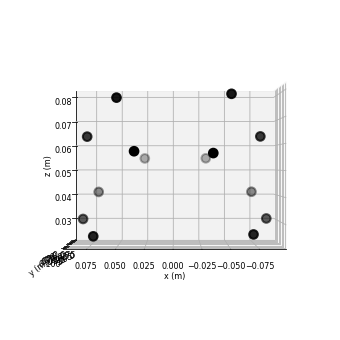

Opening raw-browser...


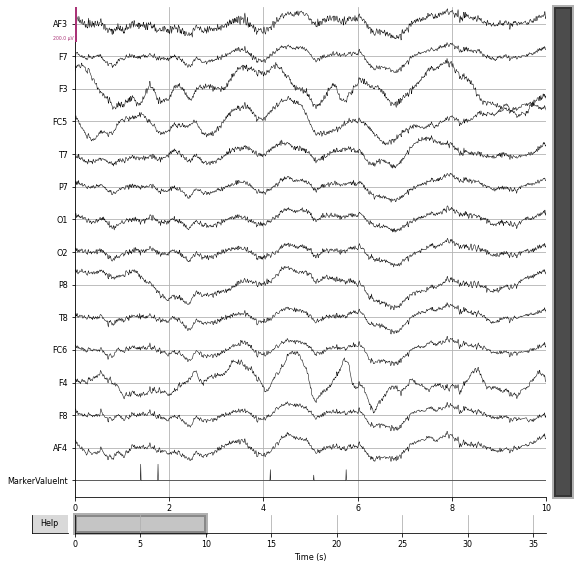

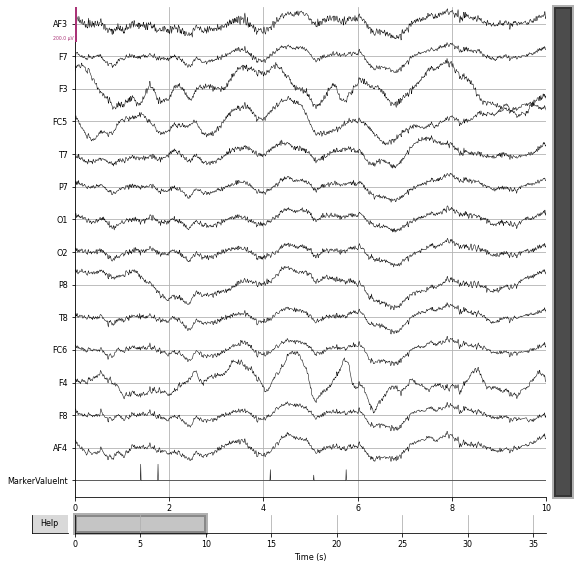

In [984]:
raw.set_montage(mont1020_new)
raw.plot_sensors(kind='3d', ch_type='eeg')
raw.plot(scalings=0.0001)

Preprocess Data

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 42 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 42.00 Hz
- Upper transition bandwidth: 10.50 Hz (-6 dB cutoff frequency: 47.25 Hz)
- Filter length: 845 samples (6.602 sec)

Effective window size : 16.000 (s)
Effective window size : 16.000 (s)


C:\Users\Joshu\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


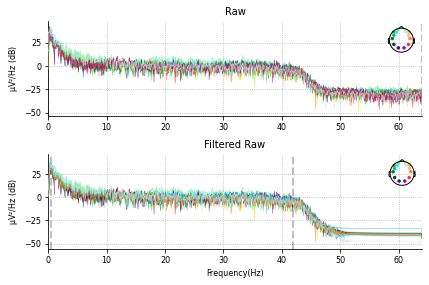

In [985]:
filtered_raw = raw.copy().filter(
    0.5, 42, l_trans_bandwidth='auto', h_trans_bandwidth='auto',
    filter_length='auto', phase='zero', fir_window='hamming',
    fir_design='firwin')
fig, ax = plt.subplots(2)
raw.plot_psd(ax=ax[0], show=False)
filtered_raw.plot_psd(ax=ax[1], show=False)
ax[0].set_title('Raw')
ax[1].set_title('Filtered Raw')
ax[1].set_xlabel('Frequency(Hz)')
fig.set_tight_layout(True)
plt.show()

Perform ICA preprocessing

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 0.1s.


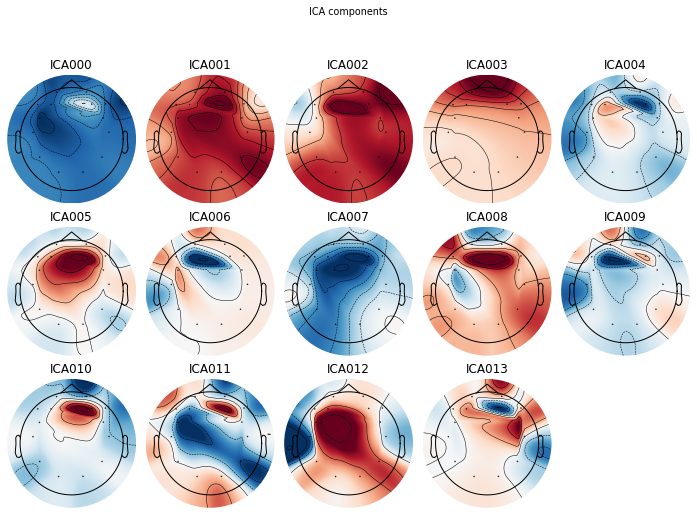

[<MNEFigure size 702x526.68 with 14 Axes>]

In [986]:
ica = mne.preprocessing.ICA(method='picard', n_components=14, random_state=0, max_iter=100000)
ica.fit(filtered_raw)
ica.plot_components(outlines='skirt')

Extract bad channels

In [987]:
bad_idx, scores = ica.find_bads_eog(raw.copy(), ch_name=['AF3', 'AF4'], threshold=2.5)
print(bad_idx)

Using EOG channels: AF3, AF4
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.2

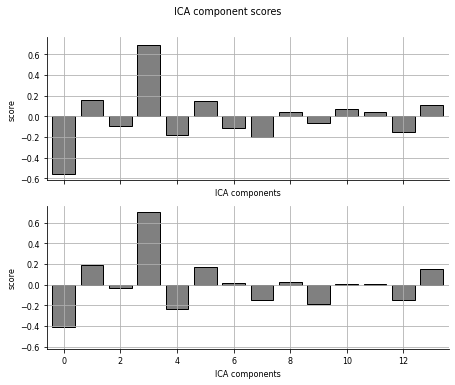

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
18 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
18 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


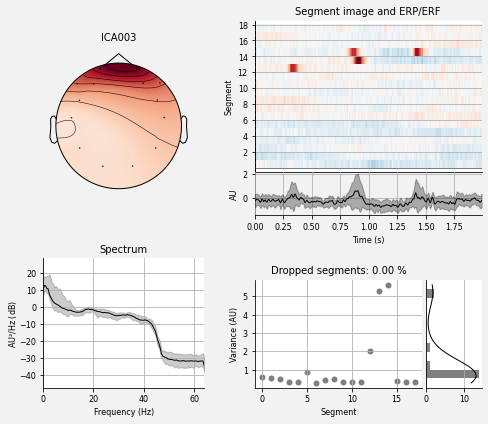

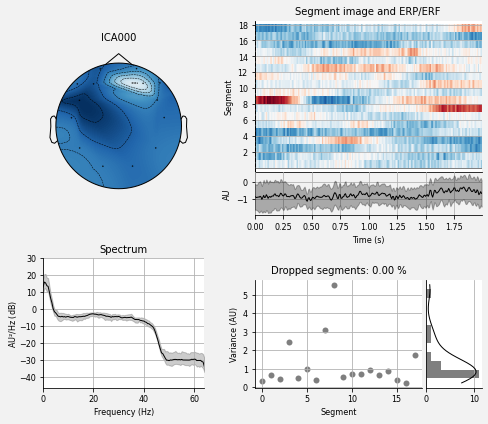

[3, 0]
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 2 ICA components
    Projecting back using 14 PCA components


<RawEDF | EEG-Game_Josh Schrock_EPOCFLEX-F0000172_EPOCFLEX_123045_2022.06.21T14.54.07.04.00.edf, 15 x 4608 (36.0 s), ~567 kB, data loaded>

In [988]:
# barplot of ICA component "ECG match" scores
ica.plot_scores(scores)

# plot diagnostics
ica.plot_properties(raw, picks=bad_idx)

ica.exclude=bad_idx
print(ica.exclude)
reconst_raw = raw.copy()
ica.apply(reconst_raw)


Compare original to ICA filtered eeg data

Opening raw-browser...


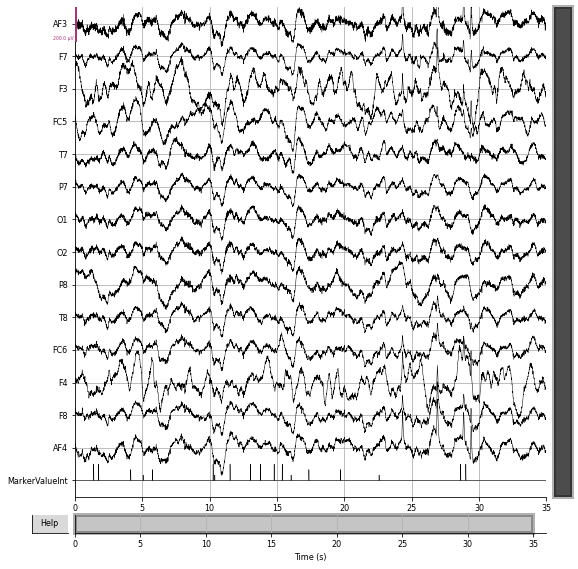

Opening raw-browser...


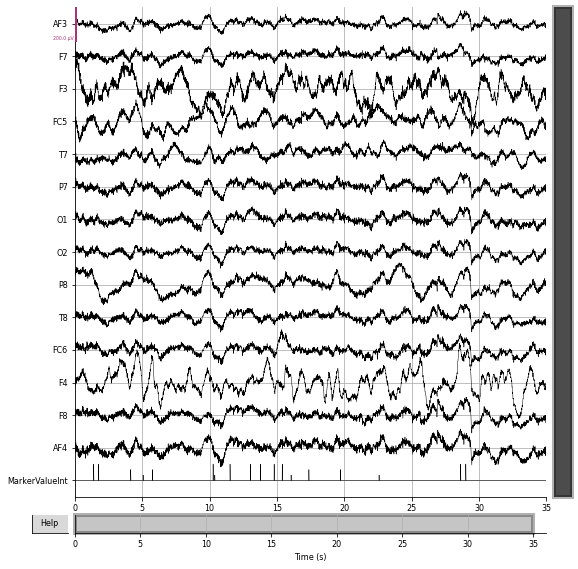

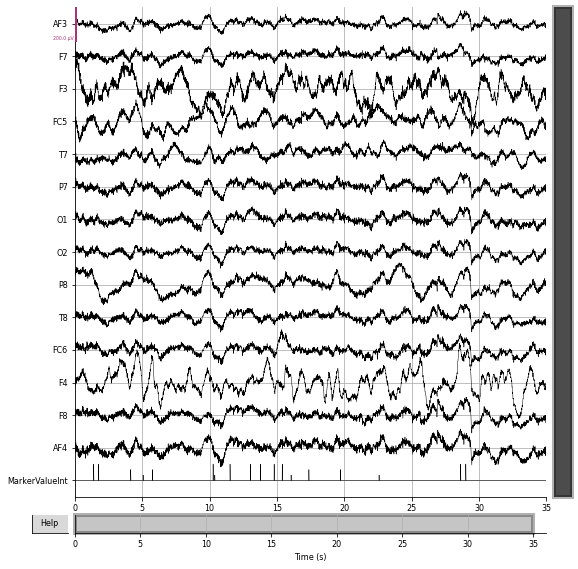

In [989]:
raw.plot(scalings=0.0001, duration=35)
reconst_raw.plot(scalings=0.0001, duration=35)

Extract events from the raw data for event based analysis. Create dictionary for event types

In [990]:
# events = mne.find_events(filtered_raw)
# print(events)
# event_types = {
#     'new_game':1,
#     'left':2,
#     'right':3,
#     'lift':4,
#     'drop':5
#     }

Find Epochs based on equally lengthed time segments instead of events

In [991]:
epochs = mne.make_fixed_length_epochs(reconst_raw, duration=8, preload=False, overlap=7)

Not setting metadata
29 matching events found
No baseline correction applied
0 projection items activated


Separate data into bands to perform band-based analysis

In [992]:
# epochs.load_data().filter(l_freq=0.5, h_freq=3)
# delta_data = epochs.get_data()
# epochs.load_data().filter(l_freq=3, h_freq=8)
# theta_data = epochs.get_data()
# epochs.load_data().filter(l_freq=8, h_freq=12)
# alpha_data = epochs.get_data()
# epochs.load_data().filter(l_freq=12, h_freq=38)
# beta_data = epochs.get_data()
# epochs.load_data().filter(l_freq=38, h_freq=42)
# gamma_data = epochs.get_data()
epochs.load_data().filter(l_freq=0.5, h_freq=42)
all_data = epochs.get_data()

Using data from preloaded Raw for 29 events and 1024 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 0.5 - 42 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 42.00 Hz
- Upper transition bandwidth: 10.50 Hz (-6 dB cutoff frequency: 47.25 Hz)
- Filter length: 845 samples (6.602 sec)



Determine connectivity for epoch set

In [993]:
corr_matrix = mne_connectivity.envelope_correlation(all_data).get_data()

C:\Users\Joshu\AppData\Local\Programs\Python\Python310\lib\site-packages\mne_connectivity\envelope.py:134: RuntimeWarning: invalid value encountered in true_divide
  data_conj_scaled /= data_mag


Plot correlation matrix for each epoch

C:\Users\Joshu\AppData\Local\Temp\ipykernel_9520\2611277925.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = plt.colorbar()


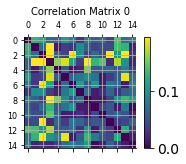

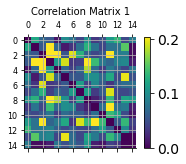

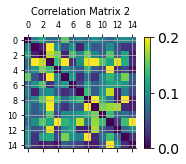

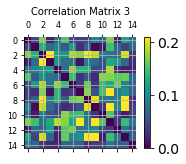

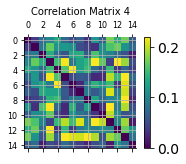

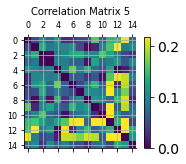

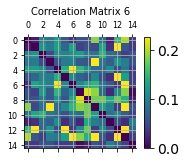

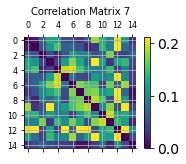

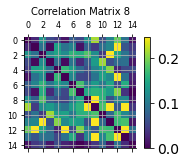

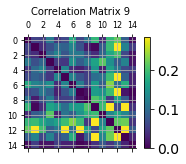

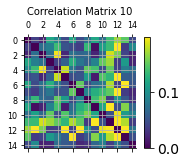

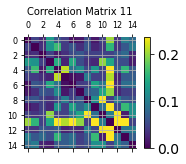

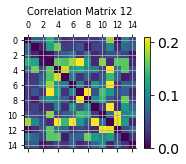

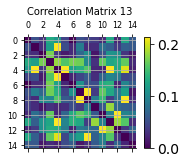

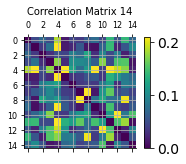

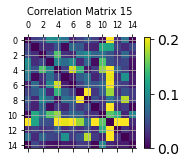

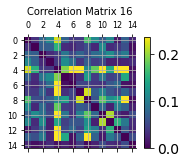

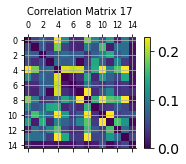

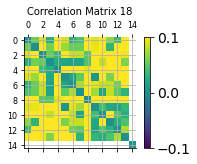

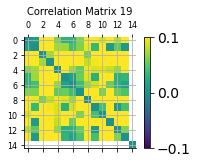

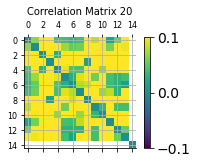

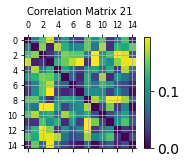

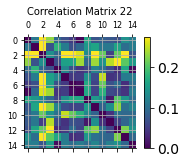

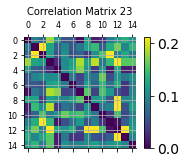

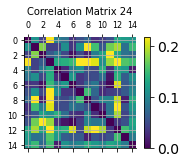

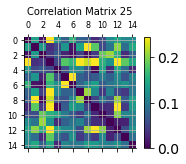

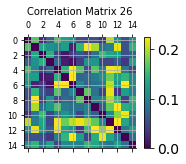

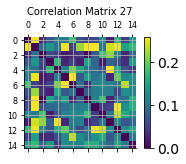

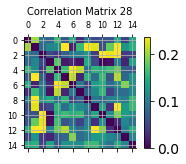

In [994]:
for i in range(len(corr_matrix)):
    color_lims = np.percentile(np.array(corr_matrix[i]), [5, 95])
    f = plt.figure(figsize=(3, 2))
    plt.matshow(corr_matrix[i], fignum=f.number, clim=color_lims)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title(f'Correlation Matrix {str(i)}')

Plot a network for each correlation matrix

In [995]:
from mne.datasets import fetch_fsaverage
fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = os.path.dirname(fs_dir)

# src = os.path.join(fs_dir, 'bem', 'fsaverage-ico-5-src.fif')
src = mne.setup_volume_source_space()
trans = 'fsaverage'  # MNE has a built-in fsaverage transformation
# Check that the locations of EEG electrodes is correct with respect to MRI
mne.viz.plot_alignment(
    raw.info, src=src, eeg=['original', 'projected'], trans=trans,
    show_axes=True, mri_fiducials=True, dig='fiducials')

# plot------------------------------
for matrix in corr_matrix:
    new_matrix = []
    for i in matrix:
        list = []
        for j in i:
            list.append(j[0])
        new_matrix.append(list)

    print(matrix)
    print(new_matrix)
    print(src[0])

    degree = mne_connectivity.degree(new_matrix, 0.15)
    stc = mne.VolSourceEstimate(degree, [src[0]['vertno']], 0, 1, 'bst_resting')
    brain = stc.plot(
        src, clim=dict(kind='percent', lims=[75, 85, 95]), colormap='gnuplot',
        subjects_dir=subjects_dir, mode='glass_brain')

0 files missing from root.txt in C:\Users\Joshu\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\Joshu\mne_data\MNE-fsaverage-data\fsaverage
Sphere                : origin at (0.0 0.0 0.0) mm
              radius  : 95.0 mm
grid                  : 5.0 mm
mindist               : 5.0 mm

Setting up the sphere...
Surface CM = (   0.0    0.0    0.0) mm
Surface fits inside a sphere with radius   95.0 mm
Surface extent:
    x =  -95.0 ...   95.0 mm
    y =  -95.0 ...   95.0 mm
    z =  -95.0 ...   95.0 mm
Grid extent:
    x = -100.0 ...  100.0 mm
    y = -100.0 ...  100.0 mm
    z = -100.0 ...  100.0 mm
68921 sources before omitting any.
28647 sources after omitting infeasible sources not within 0.0 - 95.0 mm.
24303 sources remaining after excluding the sources outside the surface and less than    5.0 mm inside.
Adjusting the neighborhood info.
Source space : MRI voxel -> MRI (surface RAS)
     0.005000  0.000000  0.000000    -100.00 mm
     0.000000  0.005000  0.000000  

RuntimeError: Could not load any valid 3D backend:
pyvistaqt: cannot import name 'vtkExtractEdges' from 'vtkmodules.vtkFiltersExtraction' (C:\Users\Joshu\AppData\Local\Programs\Python\Python310\lib\site-packages\vtkmodules\vtkFiltersExtraction.cp310-win_amd64.pyd)
notebook: cannot import name 'vtkExtractEdges' from 'vtkmodules.vtkFiltersExtraction' (C:\Users\Joshu\AppData\Local\Programs\Python\Python310\lib\site-packages\vtkmodules\vtkFiltersExtraction.cp310-win_amd64.pyd)